### Initialize notebook

In [54]:
# Torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/ak/Spring2018/ature')

from neuralnet.utils.torch_dataset import TorchPatchesGenerator
from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.trainer import NNTrainer
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 52
num_classes = len(classes)
epochs = 2
patch_size = 31
use_gpu = False

#### Images to train/validate per epoch ####
train_size = None
validation_size = 20000

### Define the network

In [64]:
class Net(nn.Module):
    def __init__(self, width, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = width
    
        self.kern_size = 5
        self.kern_stride = 2      
        self.kern_padding = 2
        self.mxp_kern_size = 2
        self.mxp_stride = 2 
        self.pool1 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv1 = nn.Conv2d(self.channels, 20, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 2
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool2 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv2 = nn.Conv2d(20, 30, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 1
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool3 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv3 = nn.Conv2d(30, 50, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 1
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool4 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv4 = nn.Conv2d(50, 30, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.linearWidth = 30*int(self.width)*int(self.width)
        self.fc1 = nn.Linear(self.linearWidth, 200)
        self.fc2 = nn.Linear(200, 40)
        self.fc3 = nn.Linear(40, 4)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, self.linearWidth)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def _update_output_size(self):       
        temp = self.width
        self.width = ((self.width - self.kern_size + 2 * self.kern_padding) / self.kern_stride) + 1
        temp1 = self.width
        self.width = ((self.width - self.mxp_kern_size)/self.mxp_stride) + 1
        print('Output width[ ' + str(temp) + ' -conv-> ' + str(temp1) + ' -maxpool-> ' + str(self.width) + ' ]')

width = 31
channels = 1
net = Net(width, channels)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

Output width[ 31 -conv-> 16.0 -maxpool-> 8.0 ]
Output width[ 8.0 -conv-> 8.0 -maxpool-> 8.0 ]
Output width[ 8.0 -conv-> 6.0 -maxpool-> 6.0 ]
Output width[ 6.0 -conv-> 4.0 -maxpool-> 4.0 ]


### Load train data

In [96]:
transform = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(40),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ])

trainset = TorchPatchesGenerator(Dirs=Dirs, patch_size=patch_size, 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file) 

### Fix skewed classes by sampling based on class weights
labels = np.array(trainset.IDs)[:,3]
_, ccounts_train = np.unique(labels, return_counts=True)
cweights_train = 1.0/ccounts_train
dweights_train = np.array([cweights_train[t] for t in labels])

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=3, 
                                          sampler=WeightedRandomSampler(dweights_train, train_size))

### 4388140 patches found.


### Load Validation Data

In [99]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

validation_set = TorchPatchesGenerator(Dirs=ValidationDirs, patch_size=patch_size, 
                                       transform=transform_test,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file) 

labels_val = np.array(validation_set.IDs)[:,3]
_, ccounts_val = np.unique(labels_val, return_counts=True)
cweights_val = 1.0/ccounts_val
dweights_val = np.array([cweights_val[t] for t in labels_val])

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=3,
                                            sampler=WeightedRandomSampler(dweights_val, 
                                                                          validation_size, replacement=True))

### 658074 patches found.


### Load test dataset

In [67]:
testset = TorchPatchesGenerator(Dirs=TestDirs, patch_size=patch_size, 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                segment_mode=True) 

testloader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                          shuffle=False, num_workers=3)

### 216778 patches found.


### Train and evaluate the Network

In [97]:
trainer = NNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], 
                    checkpoint_file='PytorchCheckpoint'+str(num_classes)+'Way.nn.tar')
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader)
# trainer.resume_from_checkpoint()

epoch:[1/2] batches:[200/289]   Loss = 0.288
epoch:[1/2] batches:[289/289]   Loss = 0.405
_________ACCURACY___of___[193/193]_batches: 89.37%
Accuracy improved. Checkpoint saved:PytorchCheckpoint2Way.nn.tar
epoch:[2/2] batches:[200/289]   Loss = 0.272
epoch:[2/2] batches:[289/289]   Loss = 0.175
_________ACCURACY___of___[193/193]_batches: 89.20%
Accuracy did not improve.


In [56]:
acc, y_pred, y_true = trainer.test(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)

######  3


### Check per-class performance

In [16]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of white : 92 %
Accuracy of green : 11 %
Accuracy of black : 98 %
Accuracy of   red :  4 %


### Convolve throughout the image to generate segmented image based on trained Network

In [ ]:
seg = np.zeros_like(testset.images[0].working_arr)
testloader.segment_mode = True
testloader.batch_size = 1
for (ID, i, j, _), image, _ in testloader:
    outputs = trainer.model(Variable(image))
    _, predicted = torch.max(outputs.data, 1)
    if predicted[0]==classes['vessel']:
        seg[i, j] = 255

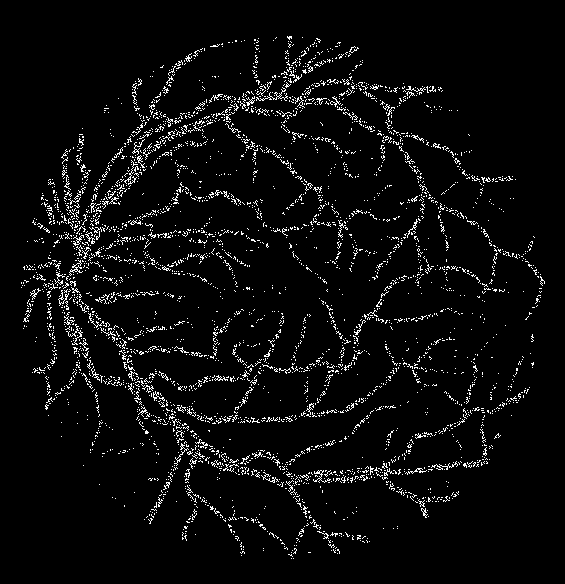

In [41]:
IMG.fromarray(seg)